![](https://upload.wikimedia.org/wikipedia/pt/8/80/Enem_logo.png)
# Projeto Tópicos Avançados em GDI - ENEM 2021
Neste projeto, desenvolvemos modelos de regressão de dados utilizando a base de dados do [ENEM 2021](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem).

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
f = open("./sample_data/README.md", "r")
print(f.read())

This directory includes a few sample datasets to get you started.

*   `california_housing_data*.csv` is California housing data from the 1990 US
    Census; more information is available at:
    https://developers.google.com/machine-learning/crash-course/california-housing-data-description

*   `mnist_*.csv` is a small sample of the
    [MNIST database](https://en.wikipedia.org/wiki/MNIST_database), which is
    described at: http://yann.lecun.com/exdb/mnist/

*   `anscombe.json` contains a copy of
    [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet); it
    was originally described in

    Anscombe, F. J. (1973). 'Graphs in Statistical Analysis'. American
    Statistician. 27 (1): 17-21. JSTOR 2682899.

    and our copy was prepared by the
    [vega_datasets library](https://github.com/altair-viz/vega_datasets/blob/4f67bdaad10f45e3549984e17e1b3088c731503d/vega_datasets/_data/anscombe.json).



## Instalação de ferramentas
Nesta seção, instalamos todas as dependências necessárias para o funcionamento de nossa regress˜åo.


In [ ]:
!pip install mlflow
!pip install optuna
!pip install sklearn
!pip install auto-sklearn
!npm install -g localtunnel


import autosklearn.regression

import optuna
import mlflow
import mlflow.sklearn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
pd.options.mode.chained_assignment = None

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
updated 1 package in 2.436s


## Coleta e separação dos dados
Como pode-se imaginar, fizemos uso de uma base de dados disponibilizada pelo governo brasileiro relativo ao ENEM 2021. Esta possuí vários tipos de dados, mas para nossa análise usaremos apenas dados relativos as **notas dos participantes**.

Para tal, pelo grande tamanho de nosso dataset, aproximadamento 2 GB de dados, utilizamos a ténica de sampleamento para prosseguir com nossa análise.

### Sampleamento
Nosso sampleamento fez uso de uma técnica muito simples, para tal, separamos as primeiras 300 mil linhas do dataset original, assim resultando em um arquivo com 300 MB.

Fizemos isto consciêntes de que essa escolha poderia gerar ruídos ou tendências em nosso dataset. Assim, para evitar isto a melhor maneira de proceder com essa operação seria fazer um sampleamento randômnico ou utilizando técnicas mais avançadas de balancemaneto de amostras.

## Dicionário
Para o correto entendimento de nosso dados, disponibilizamos [neste link](https://docs.google.com/spreadsheets/d/1-y2XLTG_AWINH6F4FKPcjfNl1yeFIPujACHJwHKMR5Y/edit?usp=sharing) os sigficados dos campos que serão trabalhados neste análise.

Também disponibilizamos o sample do dataset que usamos [neste link](https://drive.google.com/drive/folders/1e7p0jmvarkBoupnZAErkrlykCUNucI73?usp=sharing).

In [ ]:
enem = pd.read_csv("SAMPLE_MICRODADOS_ENEM_2021.csv", sep=";" ,encoding = "ISO-8859-1")

notas_columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
notas = enem[notas_columns]
colunas_notas = ['ciencias_naturais', 'ciencias_humanas', 'linguagem_codigo', 'matematica', 'redacao']
notas.columns = colunas_notas
notas.head()

,ciencias_naturais,ciencias_humanas,linguagem_codigo,matematica,redacao
0,NaN,574.6,472.6,NaN,760.0
1,505.9,551.8,498.3,461.5,560.0
2,NaN,NaN,NaN,NaN,NaN
3,580.7,678.9,638.9,659.5,780.0
4,497.7,532.4,457.6,582.6,780.0


In [ ]:
notas = notas.dropna()
notas = notas[~(notas == 0).any(axis=1)]

x = notas[['ciencias_naturais', 'ciencias_humanas', 'linguagem_codigo', 'redacao']]
y = notas['matematica']

x = x/1000
y = y/1000

xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.15)
x.head()

,ciencias_naturais,ciencias_humanas,linguagem_codigo,redacao
1,0.5059,0.5518,0.4983,0.56
3,0.5807,0.6789,0.6389,0.78
4,0.4977,0.5324,0.4576,0.78
8,0.4874,0.4765,0.4507,0.52
9,0.5076,0.5392,0.4946,0.38


# Avaliador de métricas


In [ ]:
def eval_model(ytest, y_test_pred):
  mse = mean_squared_error(ytest, y_test_pred)
  r2 = r2_score(ytest, y_test_pred)
  mape = mean_absolute_percentage_error(ytest, y_test_pred)
  return r2, mse, mape

# Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
reg_linear = LinearRegression()
model=reg_linear.fit(xtrain,ytrain)

y_test_pred = reg_linear.predict(xtest)
r2, mse, mape = eval_model(ytest, y_test_pred)
print('Best Model Stats:')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
print(f'R2: {r2}')

Training MSE:  0.005271058723057044
Test MSE:  0.005271058723057044
R2: 0.5476627885215499
Score:  0.5476627885215499


# Support Vector Machines

## PREENCHE AQUI LUCAS

In [ ]:
def save_on_mlflow(model, kernel, r2, mse, mape):
  with mlflow.start_run():
    mlflow.log_param("kernel", kernel)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mape", mape)
    mlflow.sklearn.log_model(model, "model")

def objective(trial):
  kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
  rfr = svm.SVR(kernel=kernel, gamma='scale')
  rfr.fit(xtrain, ytrain)
  
  y_test_pred = rfr.predict(xtest)
  r2, mse, mape = eval_model(ytest, y_test_pred)
  save_on_mlflow(rfr, kernel, r2, mse, mape)
  return r2  

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2022-10-01 21:26:41,422] A new study created in memory with name: no-name-a32feef0-53fa-4513-9b57-d2868935b7ce
[I 2022-10-01 21:26:50,028] Trial 0 finished with value: -0.0023985678966609303 and parameters: {'kernel': 'sigmoid'}. Best is trial 0 with value: -0.0023985678966609303.
[I 2022-10-01 21:31:33,947] Trial 1 finished with value: 0.5735544947090704 and parameters: {'kernel': 'poly'}. Best is trial 1 with value: 0.5735544947090704.
[I 2022-10-01 21:31:36,596] Trial 2 finished with value: 0.5439808495946343 and parameters: {'kernel': 'linear'}. Best is trial 1 with value: 0.5735544947090704.
[I 2022-10-01 21:31:39,716] Trial 3 finished with value: 0.5689038571096128 and parameters: {'kernel': 'rbf'}. Best is trial 1 with value: 0.5735544947090704.
[I 2022-10-01 21:31:42,773] Trial 4 finished with value: 0.5689038571096128 and parameters: {'kernel': 'rbf'}. Best is trial 1 with value: 0.5735544947090704.
[I 2022-10-01 21:31:45,852] Trial 5 finished with value: 0.5689038571096128

In [ ]:
print(f"The best parameters are : \n{study.best_params}")

The best value is : 
0.5735544947090704
The best parameters are : 
{'kernel': 'poly'}


In [ ]:
regr = svm.SVR(kernel=study.best_params['kernel'])
regr.fit(xtrain, ytrain)
y_test_pred = regr.predict(xtest)
r2, mse, mape = eval_model(ytest, y_test_pred)
print('Best Model Stats:')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
print(f'R2: {r2}')

0.5735544947090704 0.005083475998220609 0.11430333294068794


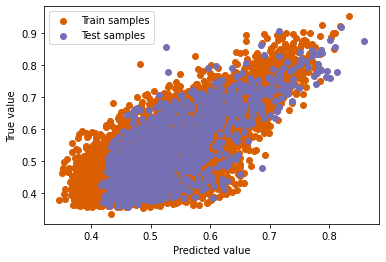

In [ ]:
plt.scatter(y_training_pred, ytrain, label="Train samples", c='#d95f02')
plt.scatter(y_test_pred, ytest, label="Test samples", c='#7570b3')
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.show()

## PREENCHE AQUI LUCAS 2


In [ ]:
def save_on_mlflow(model, degree, r2, mse, mape):
  with mlflow.start_run():
    mlflow.log_param("degree", degree)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mape", mape)
    mlflow.sklearn.log_model(model, "model")

def objective(trial):
  degree = trial.suggest_int("degree", 0, 20, 2)
  rfr = svm.SVR(kernel='poly', degree=degree, gamma='scale')
  rfr.fit(xtrain, ytrain)
  
  y_test_pred = rfr.predict(xtest)
  r2, mse, mape = eval_model(ytest, y_test_pred)
  save_on_mlflow(rfr, degree, r2, mse, mape)
  return r2  

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2022-10-01 23:35:28,023] A new study created in memory with name: no-name-fc18b65f-76c5-4b89-9e3a-9f44bdb14bda


In [ ]:
print(f"The best value is : \n{study.best_value}")
print(f"The best parameters are : \n{study.best_params}")

In [ ]:
regr = svm.SVR(kernel='poly', degree=study.best_params['degree'], gamma='scale')
regr.fit(xtrain, ytrain)
y_test_pred = regr.predict(xtest)
r2, mse, mape = eval_model(ytest, y_test_pred)
print('Best Model Stats:')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
print(f'R2: {r2}')

In [ ]:
plt.scatter(y_training_pred, ytrain, label="Train samples", c='#d95f02')
plt.scatter(y_test_pred, ytest, label="Test samples", c='#7570b3')
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.show()

# K-Neighbors

In [ ]:
def save_on_mlflow(model, n_neighbors, r2, mse, mape):
  with mlflow.start_run():
    mlflow.log_param("n_neighbors", n_neighbors)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mape", mape)
    mlflow.sklearn.log_model(model, "model")

def objective(trial):
  n_neighbors = trial.suggest_int("n_neighbors", 0, 50)
  regr = KNeighborsRegressor(n_neighbors=n_neighbors)
  regr.fit(xtrain, ytrain)
  
  y_test_pred = regr.predict(xtest)
  r2, mse, mape = eval_model(ytest, y_test_pred)
  save_on_mlflow(regr, n_neighbors, r2, mse, mape)
  return r2  

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

In [ ]:
print(f"The best parameters are : \n{study.best_params}")

In [ ]:
regr = KNeighborsRegressor(n_neighbors=study.best_params['n_neighbors'])
regr.fit(xtrain, ytrain)
y_test_pred = regr.predict(xtest)
r2, mse, mape = eval_model(ytest, y_test_pred)
print('Best Model Stats:')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
print(f'R2: {r2}')

In [ ]:
plt.scatter(y_training_pred, ytrain, label="Train samples", c='#d95f02')
plt.scatter(y_test_pred, ytest, label="Test samples", c='#7570b3')
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.show()

# SDG Regressor

In [ ]:
def save_on_mlflow(model, learning_rate, loss, penalty, r2, mse, mape):
  with mlflow.start_run():
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("loss", loss)
    mlflow.log_param("penalty", penalty)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mape", mape)
    mlflow.sklearn.log_model(model, "model")

def objective(trial):
  learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling'])
  loss = trial.suggest_categorical('loss',['squared_loss', 'huber', 'epsilon_insensitive'])
  penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])

  sgdr = SGDRegressor(learning_rate=learning_rate, loss=loss, penalty=penalty)
  sgdr.fit(xtrain, ytrain)
  
  y_test_pred = sgdr.predict(xtest)
  r2, mse, mape = eval_model(ytest, y_test_pred)
  save_on_mlflow(sgdr, learning_rate, loss, penalty, r2, mse, mape)
  return mse

study1 = optuna.create_study()
study1.optimize(objective, n_trials=10)

[I 2022-10-02 19:43:45,866] A new study created in memory with name: no-name-60ec2583-32a7-4402-a114-6141067f7dcb
[I 2022-10-02 19:43:48,535] Trial 0 finished with value: 0.005385705257452149 and parameters: {'learning_rate': 'constant', 'loss': 'squared_loss', 'penalty': 'l1'}. Best is trial 0 with value: 0.005385705257452149.
[I 2022-10-02 19:43:52,226] Trial 1 finished with value: 0.006976188609307409 and parameters: {'learning_rate': 'optimal', 'loss': 'epsilon_insensitive', 'penalty': 'l2'}. Best is trial 0 with value: 0.005385705257452149.
[I 2022-10-02 19:43:55,433] Trial 2 finished with value: 0.005350972495222186 and parameters: {'learning_rate': 'invscaling', 'loss': 'squared_loss', 'penalty': 'l1'}. Best is trial 2 with value: 0.005350972495222186.
[I 2022-10-02 19:43:58,059] Trial 3 finished with value: 0.005381903090124957 and parameters: {'learning_rate': 'invscaling', 'loss': 'epsilon_insensitive', 'penalty': 'l2'}. Best is trial 2 with value: 0.005350972495222186.
[I 20

In [ ]:
print(f"The best parameters are : \n{study1.best_params}")

The best parameters are : 
{'learning_rate': 'optimal', 'loss': 'squared_loss', 'penalty': 'elasticnet'}


In [ ]:
learning_rate = study1.best_params['learning_rate']
loss = study1.best_params['loss']
penalty = study1.best_params['penalty']
best_model = SGDRegressor(learning_rate=learning_rate, loss=loss, penalty=penalty)
best_model.fit(xtrain, ytrain)
y_test_pred = best_model.predict(xtest)
y_training_pred= best_model.predict(xtrain)
r2, mse, mape = eval_model(ytest, y_test_pred)
print('Best Model Stats:')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
print(f'R2: {r2}')

Best Model Stats:
MSE: 0.005335945246128591
MAPE: 0.11500811972682913
R2: 0.5628448937109065


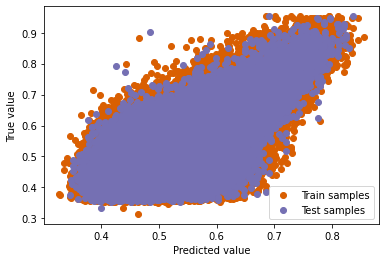

In [ ]:
plt.scatter(y_training_pred, ytrain, label="Train samples", c='#d95f02')
plt.scatter(y_test_pred, ytest, label="Test samples", c='#7570b3')
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.show()

# Random Forest Regressor

In [ ]:
def save_on_mlflow(model, n_estimators, max_depth, r2, mse, mape):
  with mlflow.start_run():
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mape", mape)
    mlflow.sklearn.log_model(model, "model")

def objective(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 600, 100)
  max_depth = trial.suggest_int('max_depth', 2, 32)

  rfr = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)
  rfr.fit(xtrain, ytrain)
  
  y_test_pred = rfr.predict(xtest)
  r2, mse, mape = eval_model(ytest, y_test_pred)
  save_on_mlflow(rfr, n_estimators, max_depth, r2, mse, mape)
  return mse

study = optuna.create_study()
study.optimize(objective, n_trials=3)

[I 2022-10-02 19:33:08,212] A new study created in memory with name: no-name-e1d8c987-343a-4cf9-8494-bd2bfeb5d395
[I 2022-10-02 19:35:06,024] Trial 0 finished with value: 0.004912236424979282 and parameters: {'n_estimators': 200, 'max_depth': 12}. Best is trial 0 with value: 0.004912236424979282.
[I 2022-10-02 19:37:10,353] Trial 1 finished with value: 0.005199142734551941 and parameters: {'n_estimators': 100, 'max_depth': 27}. Best is trial 0 with value: 0.004912236424979282.
[I 2022-10-02 19:38:43,699] Trial 2 finished with value: 0.005032273121548873 and parameters: {'n_estimators': 100, 'max_depth': 18}. Best is trial 0 with value: 0.004912236424979282.


In [ ]:
print(f"The best parameters are : \n{study.best_params}")

The best parameters are : 
{'n_estimators': 200, 'max_depth': 12}


In [ ]:
n_estimators = study.best_params['n_estimators']
max_depth = study.best_params['max_depth']
best_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
best_model.fit(xtrain, ytrain)
y_test_pred = best_model.predict(xtest)
y_training_pred= best_model.predict(xtrain)
r2, mse, mape = eval_model(ytest, y_test_pred)
print('Best Model Stats:')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
print(f'R2: {r2}')

Best Model Stats:
MSE: 0.00491298044350502
MAPE: 0.10899652917841489
R2: 0.5974969028149364


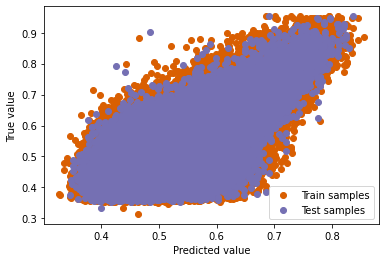

In [ ]:
plt.scatter(y_training_pred, ytrain, label="Train samples", c='#d95f02')
plt.scatter(y_test_pred, ytest, label="Test samples", c='#7570b3')
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.show()

# AutoML - Auto SciKit Learn Regressor

In [ ]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder='/tmp/autosklearn_regression_example_tmp',
)
automl.fit(xtrain, ytrain)

[WARNING] [2022-10-02 19:50:58,191:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-10-02 19:50:59,964:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-10-02 19:51:01,660:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-10-02 19:51:32,977:Client-EnsembleBuilder] No runs were available to build an ensemble from


AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     per_run_time_limit=30, time_left_for_this_task=120,
                     tmp_folder='/tmp/autosklearn_regression_example_tmp')

In [ ]:
print(automl.leaderboard())

In [ ]:
y_test_pred = automl.predict(xtest)
y_training_pred= automl.predict(xtrain)
r2, mse, mape = eval_model(ytest, y_test_pred)
print('Best Model Stats:')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
print(f'R2: {r2}')

Best Model Stats:
MSE: 0.004926669667323446
MAPE: 0.10951110258705077
R2: 0.5963753931634457


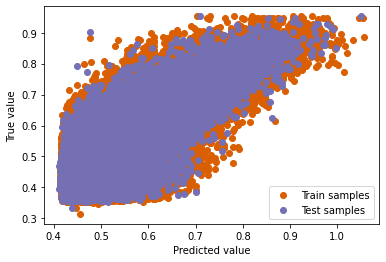

In [ ]:
plt.scatter(y_training_pred, ytrain, label="Train samples", c='#d95f02')
plt.scatter(y_test_pred, ytest, label="Test samples", c='#7570b3')
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.show()

# Interface do MLFlow

In [ ]:
!mlflow ui | lt --port 5000